<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.

Some parts of this tutorial requires pydot (`pip install pydot`) and Graphviz (see installation instructions at [https://graphviz.gitlab.io/download/](https://graphviz.gitlab.io/download/)).
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

# Neural Architecture Search with Multiple Input Tensors

In this tutorial we will extend on the previous [basic NAS tutorial](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/notebooks/04_NAS_basic/tutorial_04.html) to allow for varying numbers of input tensors. This calls for the construction of a novel search space where the different input tensors may be connected to any of the variable node operations within the search space. The data use for this tutorial is provided in this repository and is a multifidelity surrogate modeling data set obtained from the [Brannin function](https://www.sfu.ca/~ssurjano/branin.html). In addition, to the independent variables for this modeling task, low and medium fidelity estimates of the output variable are used as additional inputs to the eventual high fidelity surrogate. Thus, this requires multiple input tensors which may independently or jointly interact with the neural architecture.

## Data from Brannin Function
First, we will look at the `load_data` function that loads and returns the training and validation data from the multifidelity [Brannin function](https://www.sfu.ca/~ssurjano/branin.html). This dataset is provided in the [deephyper/tutorials repository](https://github.com/deephyper/tutorials).


The output interface of the ``load_data`` function is important when you have several inputs or outputs. In this case, for the inputs we have a list of 3 numpy arrays.

In [2]:
import os
import numpy as np


def load_data():
    """Here we are loading data that has multiple inputs for the same output.
    Our goal is to not make ONE tensor with all inputs but have separate input tensors.
    """

    data = np.load("data.npz") # Data from the Brannin function

    xtrain = data["xtrain"]  # Independent variables (input tensor 1)
    ytrain_lf = data["ytrain_lf"]  # Low fidelity variable (input tensor 2)
    ytrain_mf = data["ytrain_mf"]  # Medium fidelity variable (input tensor 3)
    ytrain_hf = data["ytrain_hf"]  # High fidelity variable (output tensor)

    xtest = data["xtest"]
    ytest_lf = data["ytest_lf"]
    ytest_mf = data["ytest_mf"]
    ytest_hf = data["ytest_hf"]

    return ([xtrain, ytrain_lf, ytrain_mf], ytrain_hf), ([xtest, ytest_lf, ytest_mf], ytest_hf)

## Neural Architecture Search Space

Now we define a neural architecture search space with multiple inputs. In the `build(self,...)` method we can see that 3 input nodes are automatically created based on the defined `input_shape`:

```python
...
self.ss = KSearchSpace(input_shape, output_shape)

# Three input tensors are automatically created based on the `input_shape`
input_0, input_1, input_2 = self.ss.input_nodes
...
```

In [3]:
import collections

import tensorflow as tf

from deephyper.nas.space import KSearchSpace, SpaceFactory
from deephyper.nas.space.node import ConstantNode, VariableNode

from deephyper.nas.space.op.basic import Zero
from deephyper.nas.space.op.connect import Connect
from deephyper.nas.space.op.merge import AddByProjecting
from deephyper.nas.space.op.op1d import Identity

from deephyper.nas.space.op import operation

Dense = operation(tf.keras.layers.Dense)
Concatenate = operation(tf.keras.layers.Concatenate)


class MultiInputsResNetMLPFactory(SpaceFactory):
    def build(
        self, input_shape=[(2,), (1,), (1,)], output_shape=(1,), num_layers=3, **kwargs
    ):

        assert len(input_shape) == 3

        self.ss = KSearchSpace(input_shape, output_shape)

        # Three input tensors are automatically created based on the `input_shape`
        input_0, input_1, input_2 = self.ss.input_nodes

        concat = ConstantNode(Concatenate())
        self.ss.connect(input_0, concat)
        self.ss.connect(input_1, concat)
        self.ss.connect(input_2, concat)

        # Input anchors (recorded so they can be connected to anywhere
        # in the architecture)
        input_anchors = [input_1, input_2]

        # Creates a Queue to store outputs of the 3 previously created  layers
        # to create potential residual connections
        skip_anchors = collections.deque([input_0], maxlen=3)

        prev_input = concat
        for _ in range(num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)

            self.ss.connect(prev_input, dense)

            # ConstantNode to merge possible residual connections from the different
            # input tensors (input_0, input_1, input_2)
            merge_0 = ConstantNode()
            merge_0.set_op(AddByProjecting(self.ss, [dense], activation="relu"))

            # Creates potential connections to the various input tensors
            for anchor in input_anchors:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self.ss, anchor))
                self.ss.connect(skipco, merge_0)

            # ConstantNode to merge possible
            merge_1 = ConstantNode()
            merge_1.set_op(AddByProjecting(self.ss, [merge_0], activation="relu"))

            # a potential connection to the variable nodes (vnodes) of the previous layers
            for anchor in skip_anchors:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self.ss, anchor))
                self.ss.connect(skipco, merge_1)

            # ! for next iter
            prev_input = merge_1
            skip_anchors.append(prev_input)

        output_node = ConstantNode(Dense(output_shape[0]))
        self.ss.connect(prev_input, output_node)

        return self.ss

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case

        activations = [
            tf.keras.activations.linear,
            tf.keras.activations.relu,
            tf.keras.activations.tanh,
            tf.keras.activations.sigmoid,
        ]
        for units in range(16, 97, 16):
            for activation in activations:
                node.add_op(Dense(units=units, activation=activation))


def create_search_space(input_shape=[(2,), (1,), (1,)], output_shape=(1,), **kwargs):
    return MultiInputsResNetMLPFactory()(input_shape, output_shape, **kwargs)

Visualize a randomly generated neural network from this search space:

2021-10-07 12:23:25.340249: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


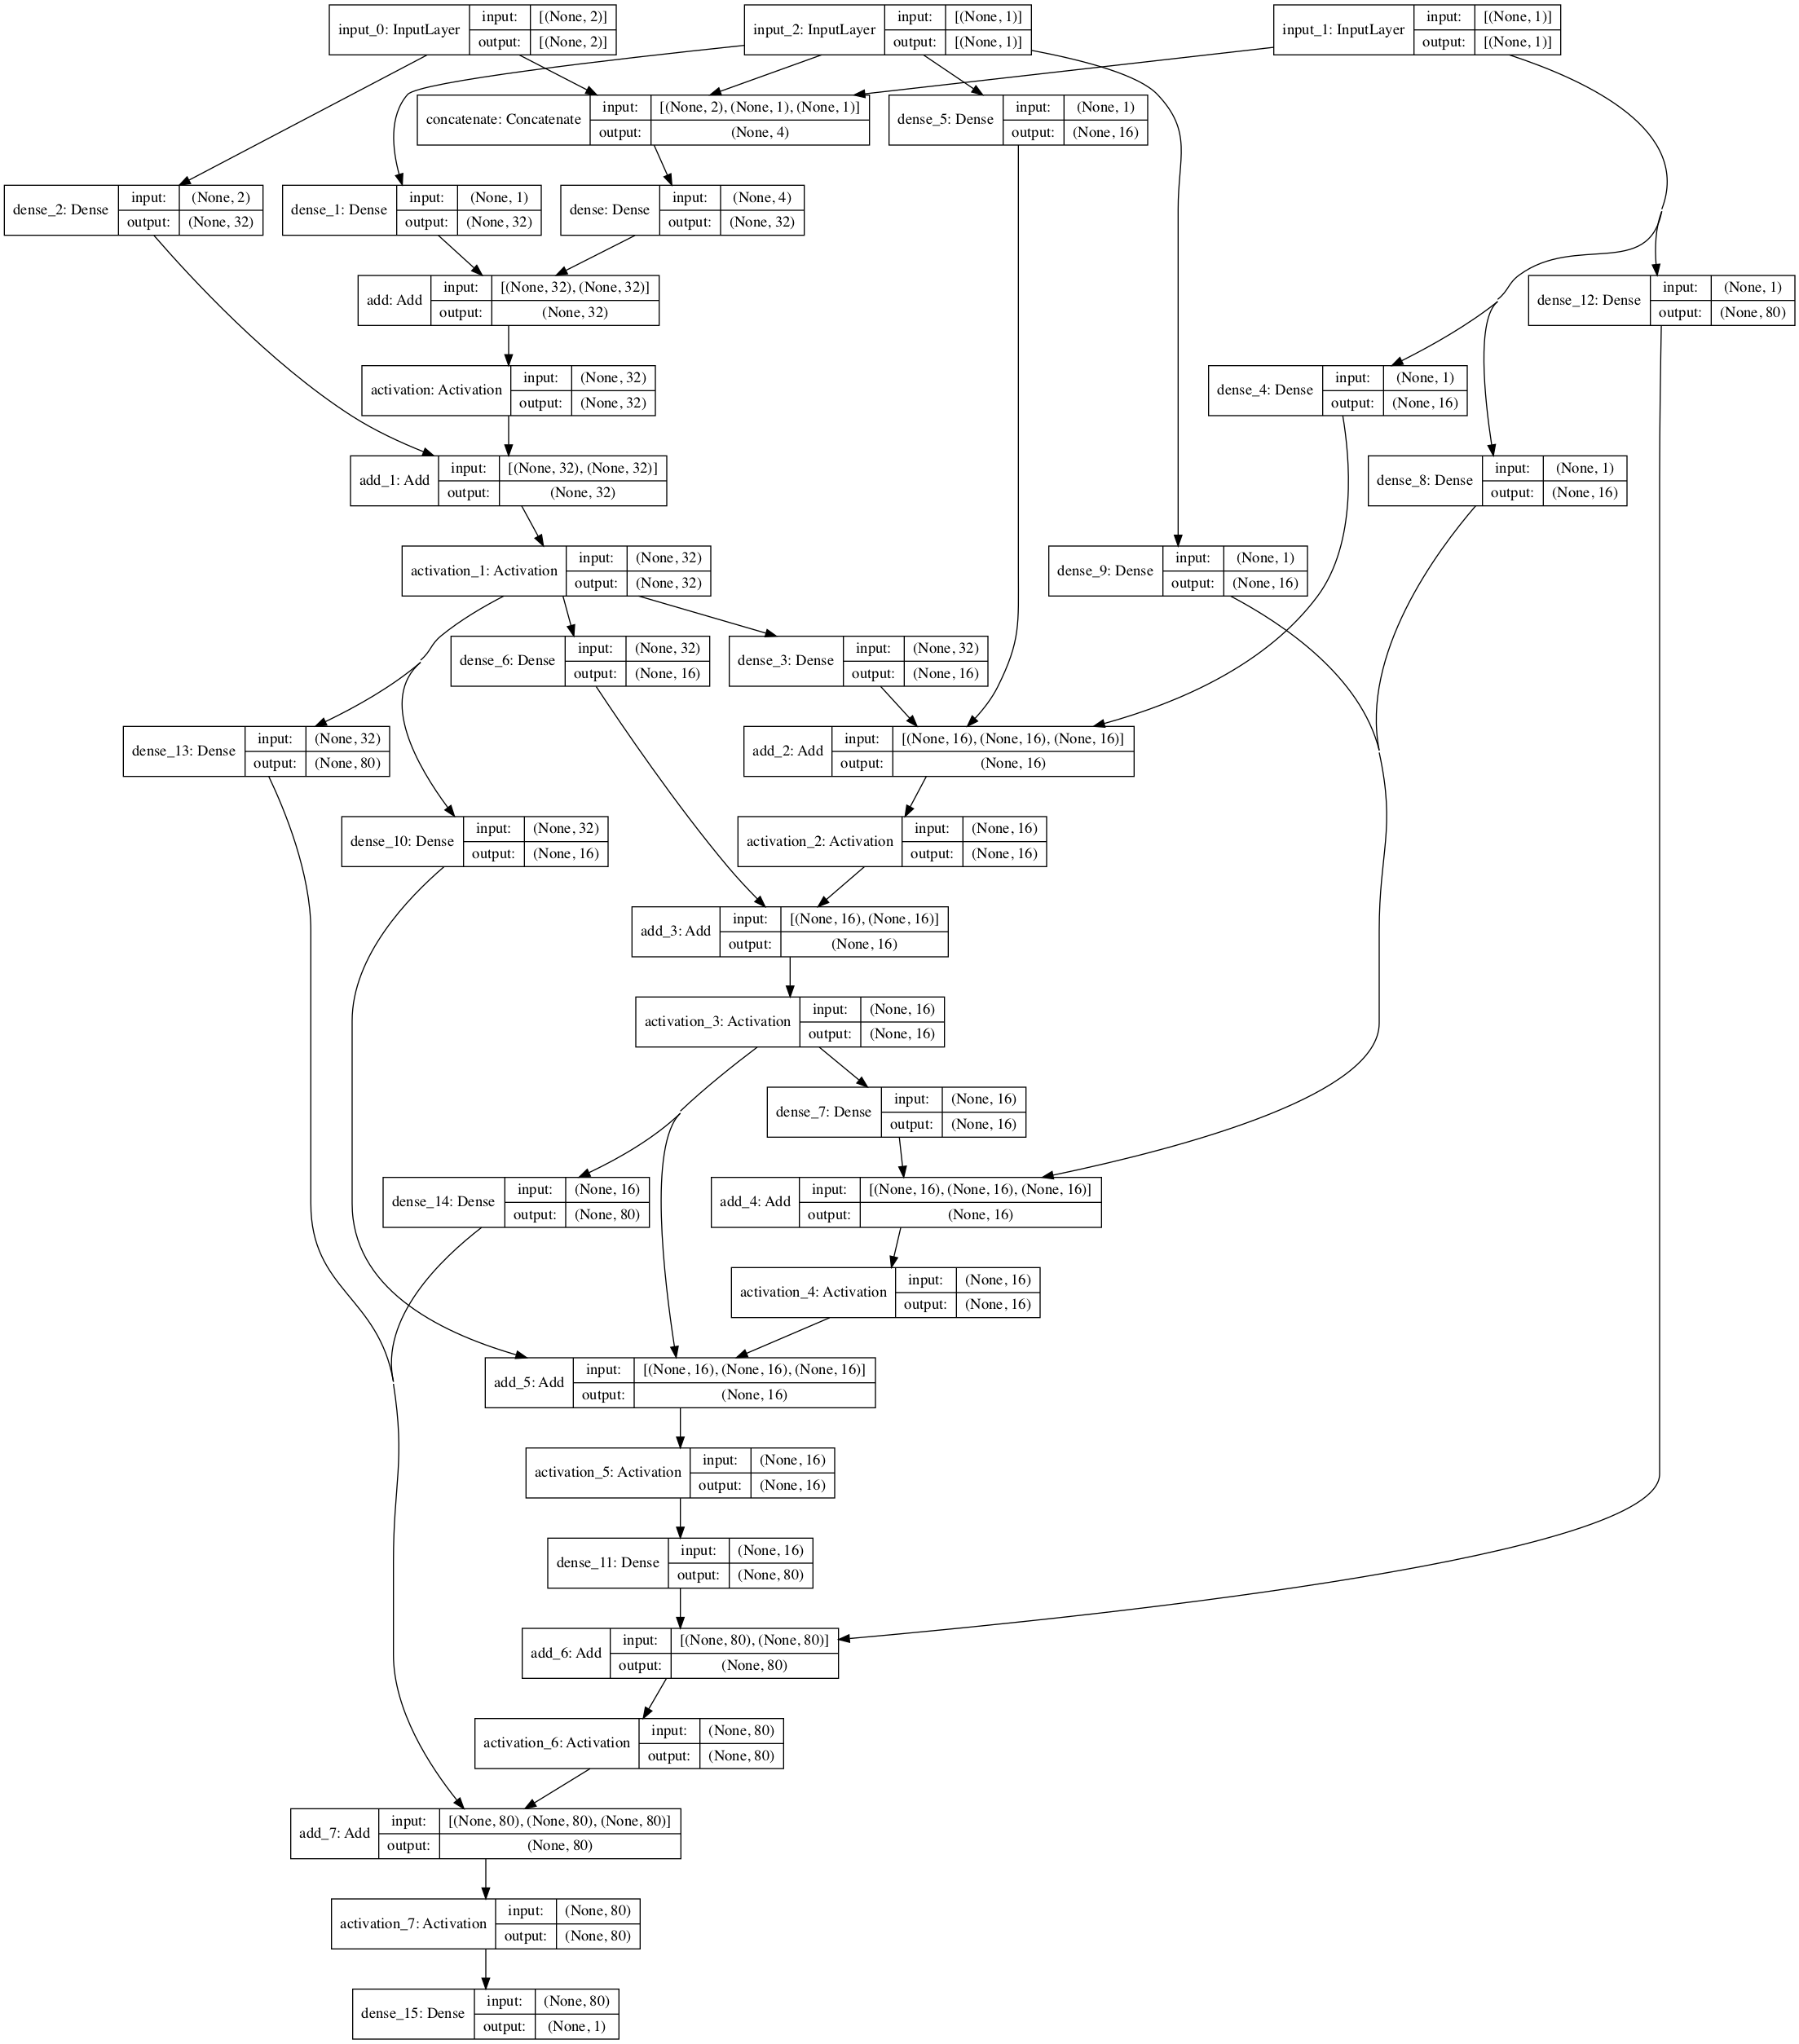

In [4]:
shapes = dict(input_shape=[(2,), (1,), (1,)], output_shape=(1,))
factory = MultiInputsResNetMLPFactory()
factory.plot_model(**shapes, num_layers=4)

## Neural Architecture Search Problem

Now, let us define the neural architecture search problem:

In [5]:
from deephyper.problem import NaProblem

problem = NaProblem(seed=2019)

problem.load_data(load_data)

problem.search_space(create_search_space, num_layers=3)

problem.hyperparameters(
    batch_size=64,
    learning_rate=0.001,
    optimizer="adam",
    num_epochs=200,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5  # or 'val_acc' ?
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem.loss("mse")

problem.metrics(["r2"])

problem.objective("val_r2")

problem

Problem is:
 * SEED = 2019 *
    - search space   : __main__.create_search_space
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 64
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 200
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}, 'ModelCheckpoint': {'monitor': 'val_loss', 'mode': 'min', 'save_best_only': True, 'verbose': 0, 'filepath': 'model.h5', 'save_weights_only': False}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2
    - post-training  : None

## Running the Search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function defined previously.

In [6]:
from deephyper.evaluator.evaluate import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.nas.run.alpha import run

evaluator = Evaluator.create(run,
                             method="ray",
                             method_kwargs={
                                 "address": None,
                                 "num_cpus": 2,
                                 "num_cpus_per_task": 1,
                                 "callbacks": [LoggerCallback()]
                             })

print("Number of workers: ", evaluator.num_workers)

2021-10-07 12:23:28,903	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


Number of workers:  2


<div class="alert alert-info">
    
<b>Tip</b> 
    
You can open the ray-dashboard at an address like <a>http://127.0.0.1:port</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [7]:
from deephyper.search.nas.random import Random

search = Random(problem, evaluator)

In [8]:
results = search.search(10)

(pid=62119) 2021-10-07 12:23:33.139111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=62119) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=62120) 2021-10-07 12:23:33.138954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=62120) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=62119) 2021-10-07 12:23:33.727792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
(pid=62120) 2021-10-07 12:23:33.780561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:1

[00001] -- best objective: 0.35128 -- received objective: 0.35128
[00002] -- best objective: 0.35128 -- received objective: 0.32973
[00003] -- best objective: 0.35128 -- received objective: -1.70970
[00004] -- best objective: 0.88777 -- received objective: 0.88777
[00005] -- best objective: 0.88777 -- received objective: 0.76241
[00006] -- best objective: 0.88777 -- received objective: 0.80779
[00007] -- best objective: 0.88777 -- received objective: -9.38778
[00008] -- best objective: 0.88777 -- received objective: 0.58690
[00009] -- best objective: 0.88777 -- received objective: 0.49043
[00010] -- best objective: 0.88777 -- received objective: 0.77274


## Analyse the Results

In [9]:
results

,arch_seq,id,objective,elapsed_sec,duration
0,"[23, 1, 1, 0, 9, 0, 0, 1, 0, 8, 0, 0, 1, 0, 1]",1,0.351282,12.617720,10.373351
1,"[6, 0, 0, 1, 13, 1, 0, 1, 1, 23, 1, 1, 1, 0, 0]",2,0.329727,16.905588,14.661184
2,"[15, 1, 1, 1, 7, 0, 0, 0, 0, 7, 0, 1, 1, 0, 0]",3,-1.709702,25.045864,12.427181
3,"[16, 0, 0, 1, 15, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1]",4,0.887770,27.578823,10.672335
4,"[17, 1, 0, 1, 17, 1, 1, 1, 0, 10, 0, 1, 1, 1, 0]",5,0.762405,31.328105,6.281435
5,"[17, 1, 0, 1, 16, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0]",6,0.807788,37.455595,9.875189
6,"[11, 0, 1, 0, 1, 0, 1, 1, 1, 12, 0, 0, 0, 1, 0]",7,-9.387781,43.496946,12.168072
7,"[5, 1, 0, 0, 15, 1, 0, 0, 1, 17, 0, 1, 1, 1, 0]",8,0.586897,44.019491,6.562847
8,"[14, 1, 0, 0, 24, 1, 1, 1, 0, 3, 1, 0, 1, 1, 0]",9,0.490429,53.701570,10.203767
9,"[10, 0, 1, 1, 3, 0, 0, 0, 0, 4, 1, 1, 0, 1, 1]",10,0.772744,55.576166,11.555831


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [10]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[16, 0, 0, 1, 15, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1]'
  duration: 10.6723349094
  elapsed_sec: 27.5788228512
  id: 4
  objective: 0.8877702951
'1':
  arch_seq: '[17, 1, 0, 1, 16, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0]'
  duration: 9.8751888275
  elapsed_sec: 37.4555950165
  id: 6
  objective: 0.8077878952
'2':
  arch_seq: '[10, 0, 1, 1, 3, 0, 0, 0, 0, 4, 1, 1, 0, 1, 1]'
  duration: 11.5558309555
  elapsed_sec: 55.5761659145
  id: 10
  objective: 0.7727435827



Output the best neural network architecture:

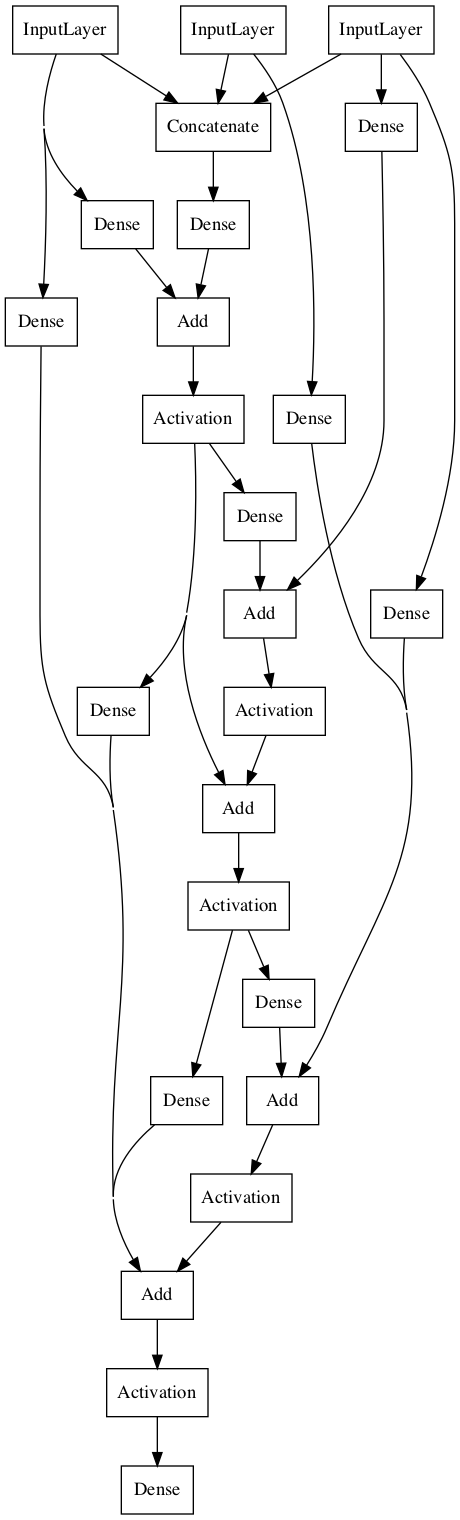

In [11]:
import json

best_config = results.iloc[results.objective.argmax()][:-3].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
factory.plot_model(**shapes, ops=arch_seq, show_shapes=False, show_layer_names=False, num_layers=3) 